# Определение выгодного тарифа для телеком компании

## Описание проекта.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год.\
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

Тариф «Смарт»\
Ежемесячная плата: 550 рублей\
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика\
Стоимость услуг сверх тарифного пакета:\
Минута разговора — 3 рубля.\
Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх.\
Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.\
Сообщение — 3 рубля. 1 Гб интернет-трафика — 200 рублей.

Тариф «Ультра»\
Ежемесячная плата: 1950 рублей\
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика\
Стоимость услуг сверх тарифного пакета:\
Минута разговора — 1 рубль;\
Сообщение — 1 рубль;\
1 Гб интернет-трафика: 150 рублей.

## Описание данных

Таблица users — информация о пользователях:

user_id — уникальный идентификатор пользователя\
first_name — имя пользователя\
last_name — фамилия пользователя\
age — возраст пользователя (годы)\
reg_date — дата подключения тарифа (день, месяц, год)\
churn_date — дата прекращения пользования тарифом (если значение пропущено, значит, тариф ещё действовал на момент выгрузки данных)\
city — город проживания пользователя\
tarif — название тарифного плана



Таблица calls — информация о звонках:

id — уникальный номер звонка\
call_date — дата звонка\
duration — длительность звонка в минутах\
user_id — идентификатор пользователя, сделавшего звонок



Таблица messages — информация о сообщениях:

id — уникальный номер звонка\
message_date — дата сообщения\
user_id — идентификатор пользователя, отправившего сообщение



Таблица internet — информация об интернет-сессиях:

id — уникальный номер сессии\
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)\
session_date — дата интернет-сессии\
user_id — идентификатор пользователя



Таблица tariffs — информация о тарифах:

tariff_name — название тарифа\
rub_monthly_fee — ежемесячная абонентская плата в рублях\
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату\
messages_included — количество сообщений в месяц, включённых в абонентскую плату\
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)\
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)\
rub_per_message — стоимость отправки сообщения сверх тарифного пакета\
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [2]:
import pandas as pd
from scipy import stats as st
import numpy as np

### Откроем файлы с данными и изучим общую информацию

In [3]:
try:
   calls = pd.read_csv('/datasets/calls.csv')
except:
   calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')

Выведем первые 5 строк датафрейма `calls`.

In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


 Выведем основную информацию для датафрейма `calls` с помощью метода `info()`.

In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


С помощью метода `hist()` выведем гистограмму для столбца с продолжительностью звонков.

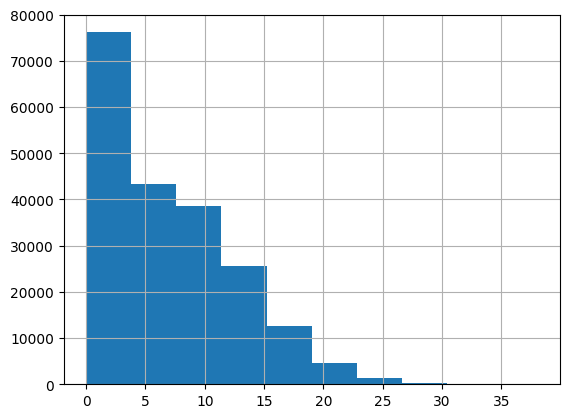

In [6]:
calls['duration'].hist();

Откроем файл `/datasets/internet.csv`, сохраним датафрейм в переменную `sessions`.

In [7]:
try:
   sessions = pd.read_csv('/datasets/internet.csv')
except:
   sessions = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')

Выведем первые 5 строк датафрейма `sessions`.

In [8]:
sessions.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Выведем основную информацию для датафрейма sessions с помощью метода `info()`. 

In [9]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


С помощью метода `hist()` выведем гистограмму для столбца с количеством потраченных мегабайт.

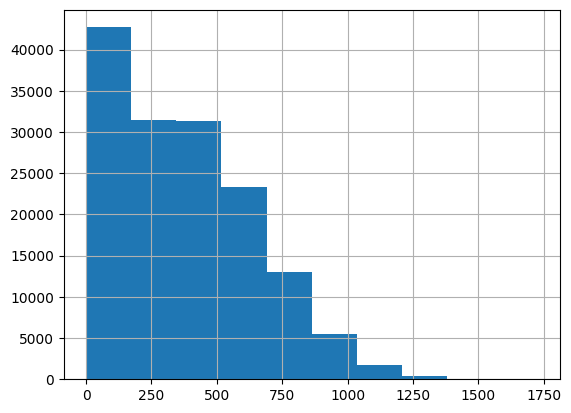

In [10]:
sessions['mb_used'].hist();

Откройем файл `/datasets/messages.csv`, сохраним датафрейм в переменную `messages`.

In [11]:
try:
   messages = pd.read_csv('/datasets/messages.csv')
except:
   messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')

Выведем первые 5 строк датафрейма `messages`.

In [12]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Выведем основную информацию для датафрейма `messages` с помощью метода `info()`. 

In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Откроем файл `/datasets/tariffs.csv`, сохраните датафрейм в переменную `tariffs`.

In [15]:
try:
   tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
   tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')

Выведем весь датафрейм `tariffs`.

In [16]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Выведем основную информацию для датафрейма `tariffs` с помощью метода `info()`.

In [17]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Откроем файл `/datasets/users.csv`, сохраним датафрейм в переменную `users`.

In [18]:
try:
   users = pd.read_csv('/datasets/users.csv')
except:
   users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

Выведем первые 5 строк датафрейма `users`.

In [19]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Выведем основную информацию для датафрейма `users` с помощью метода `info()`.

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


## Подготовим данные

Приведем столбцы

- `reg_date` из таблицы `users`
- `churn_date` из таблицы `users`
- `call_date` из таблицы `calls`
- `message_date` из таблицы `messages`
- `session_date` из таблицы `sessions`

к новому типу с помощью метода `to_datetime()`.

In [21]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d %H:%M')# обработка столбца reg_date
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d %H:%M')# обработка столбца churn_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M')# обработка столбца call_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M')# обработка столбца message_date
sessions['session_date'] = pd.to_datetime(sessions['session_date'], format='%Y-%m-%d %H:%M')# обработка столбца session_date

В данных найдём звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки.

В столбце `duration` датафрейма `calls` значения дробные. Округлим значения столбца `duration` вверх с помощью метода `numpy.ceil()` и приведем столбец `duration` к типу `int`.

In [22]:
import numpy as np
# округление значений столбца duration с помощью np.ceil() и приведение типа к int
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)

Удалим столбец `Unnamed: 0` из датафрейма `sessions`. Столбец с таким названием возникает, когда данные сохраняют с указанием индекса (`df.to_csv(..., index=column)`).

In [22]:
sessions = sessions.drop(columns=['Unnamed: 0'], axis=1)

Создадим столбец `month` в датафрейме `calls` с номером месяца из столбца `call_date`.

In [23]:
calls['month'] = calls['call_date'].dt.month

Создадим столбец `month` в датафрейме `messages` с номером месяца из столбца `message_date`.

In [24]:
messages['month'] = messages['message_date'].dt.month

Создадим столбец `month` в датафрейме `sessions` с номером месяца из столбца `session_date`.

In [25]:
sessions['month'] = sessions['session_date'].dt.month

Посчитаем количество сделанных звонков разговора для каждого пользователя по месяцам.

In [27]:
calls_per_month = calls.groupby(['user_id', 'month']).agg(calls=('duration', 'count')) # подсчёт количества звонков

In [34]:
calls_per_month.head(30) # вывод 30 первых строк на экран

calls
user_id month       
1000    5         22
        6         43
        7         47
        8         52
        9         58
        10        57
        11        43
        12        46
1001    11        59
        12        63
1002    6         15
        7         26
        8         42
        9         36
        10        33
        11        32
        12        33
1003    8         55
        9        134
        10       108
        11       115
        12       108
1004    5          9
        6         31
        7         22
        8         19
        9         26
        10        29
        11        19
        12        21

Посчитаем количество израсходованных минут разговора для каждого пользователя по месяцам и сохраним в переменную `minutes_per_month`.
Выведем первые 30 строчек `minutes_per_month`.

In [30]:
minutes_per_month = calls.groupby(['user_id', 'month']).agg(minutes=('duration', 'sum'))# подсчёт израсходованных минут для каждого пользователя по месяцам

In [31]:
minutes_per_month.head(30) # вывод первых 30 строк на экран

minutes
user_id month         
1000    5       150.06
        6       158.90
        7       318.80
        8       389.87
        9       440.14
        10      328.45
        11      319.04
        12      312.98
1001    11      408.12
        12      391.34
1002    6       110.37
        7       204.75
        8       269.71
        9       195.85
        10      199.48
        11      228.03
        12      222.98
1003    8       355.67
        9       904.89
        10      809.07
        11      775.39
        12      755.50
1004    5        32.29
        6       159.14
        7       124.42
        8       128.01
        9       110.57
        10      133.61
        11      109.72
        12      123.45

Посчитаем количество отправленных сообщений по месяцам для каждого пользователя и сохраним в переменную `messages_per_month`.
Выведем первые 30 строчек `messages_per_month`.

In [32]:
messages_per_month = messages.groupby(['user_id', 'month']).agg(messages=('message_date', 'count')) # подсчёт количества отправленных сообщений для каждого пользователя по месяцам

In [33]:
messages_per_month.head(30)# вывод первых 30 строк на экран

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
        10           73
        11           58
        12           70
1002    6             4
        7            11
        8            13
        9             4
        10           10
        11           16
        12           12
1003    8            37
        9            91
        10           83
        11           94
        12           75
1004    5            95
        6           134
        7           181
        8           151
        9           146
        10          165
        11          158
        12          162
1005    1             7
        2            38

Посчитаем количество потраченных мегабайт по месяцам для каждого пользователя и сохраним в переменную `sessions_per_month`.

In [35]:
sessions_per_month = sessions.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})# подсчёт потраченных мегабайт для каждого пользователя по месяцам

In [36]:
sessions_per_month.head(30) # вывод первых 30 строк на экран

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
        10     14702.49
        11     14756.47
        12      9817.61
1001    11     18429.34
        12     14036.66
1002    6      10856.82
        7      17580.10
        8      20319.26
        9      16691.08
        10     13888.25
        11     18587.28
        12     18113.73
1003    8       8565.21
        9      12468.87
        10     14768.14
        11     11356.89
        12     10121.53
1004    5      13403.98
        6      17600.02
        7      22229.58
        8      28584.37
        9      15109.03
        10     18475.44
        11     15616.02
        12     18021.04

### Анализ данных и подсчёт выручки

Объединяем все посчитанные выше значения в один датафрейм `user_behavior`.
Для каждой пары "пользователь - месяц" будут доступны информация о тарифе, количестве звонков, сообщений и потраченных мегабайтах.

In [37]:
users['churn_date'].count() / users['churn_date'].shape[0] * 100

7.6

Расторгли договор 7.6% клиентов из датасета

In [38]:
user_behavior = calls_per_month\
    .merge(messages_per_month, left_index=True, right_index=True, how='outer')\
    .merge(sessions_per_month, left_index=True, right_index=True, how='outer')\
    .merge(minutes_per_month, left_index=True, right_index=True, how='outer')\
    .reset_index()\
    .merge(users, how='left', left_on='user_id', right_on='user_id')\

user_behavior.head()

,user_id,month,calls,messages,mb_used,minutes,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,22.0,22.0,2253.49,150.06,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,43.0,60.0,23233.77,158.90,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,47.0,75.0,14003.64,318.80,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,52.0,81.0,14055.93,389.87,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,58.0,57.0,14568.91,440.14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Проверим пропуски в таблице `user_behavior` после объединения:

In [39]:
user_behavior.isna().sum()

user_id          0
month            0
calls           40
messages       497
mb_used         11
minutes         40
age              0
churn_date    3027
city             0
first_name       0
last_name        0
reg_date         0
tariff           0
dtype: int64

Заполним образовавшиеся пропуски в данных:

In [40]:
user_behavior['calls'] = user_behavior['calls'].fillna(0)
user_behavior['minutes'] = user_behavior['minutes'].fillna(0)
user_behavior['messages'] = user_behavior['messages'].fillna(0)
user_behavior['mb_used'] = user_behavior['mb_used'].fillna(0)

Присоединяем информацию о тарифах

In [41]:
# переименование столбца tariff_name на более простое tariff

tariffs = tariffs.rename(
    columns={
        'tariff_name': 'tariff'
    }
)

In [42]:
user_behavior = user_behavior.merge(tariffs, on='tariff')

Считаем количество минут разговора, сообщений и мегабайт, превышающих включенные в тариф


In [43]:
user_behavior['paid_minutes'] = user_behavior['minutes'] - user_behavior['minutes_included']
user_behavior['paid_messages'] = user_behavior['messages'] - user_behavior['messages_included']
user_behavior['paid_mb'] = user_behavior['mb_used'] - user_behavior['mb_per_month_included']

for col in ['paid_messages', 'paid_minutes', 'paid_mb']:
    user_behavior.loc[user_behavior[col] < 0, col] = 0

Переводим превышающие тариф мегабайты в гигабайты и сохраняем в столбец `paid_gb`

In [44]:
user_behavior['paid_gb'] = np.ceil(user_behavior['paid_mb'] / 1024).astype(int)

Считаем выручку за минуты разговора, сообщения и интернет

In [45]:
user_behavior['cost_minutes'] = user_behavior['paid_minutes'] * user_behavior['rub_per_minute']
user_behavior['cost_messages'] = user_behavior['paid_messages'] * user_behavior['rub_per_message']
user_behavior['cost_gb'] = user_behavior['paid_gb'] * user_behavior['rub_per_gb']

Считаем помесячную выручку с каждого пользователя, она будет храниться в столбец `total_cost`

In [46]:
user_behavior['total_cost'] = \
      user_behavior['rub_monthly_fee']\
    + user_behavior['cost_minutes']\
    + user_behavior['cost_messages']\
    + user_behavior['cost_gb']

Датафрейм `stats_df` для каждой пары "месяц-тариф" будет хранить основные характеристики

In [47]:
# сохранение статистических метрик для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = user_behavior.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'minutes', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,8513.72,18.24,193.04,20.81,6444.68,16.20,146.33,20.5,7096.18,15.0,156.22
1,1,ultra,59.44,13140.68,33.78,404.78,41.64,6865.35,30.67,254.62,51.0,14791.37,32.0,359.65
2,2,smart,40.19,11597.05,24.09,282.96,25.39,6247.35,21.75,180.98,38.5,12553.71,20.0,242.90
3,2,ultra,41.54,11775.94,21.96,280.57,40.97,10644.64,26.77,280.94,25.0,7327.12,5.5,156.55
4,3,smart,54.32,15104.16,31.86,367.88,25.54,5828.24,26.80,181.54,59.0,15670.25,23.0,386.36
5,3,ultra,67.68,17535.55,32.30,462.36,44.84,10951.79,41.62,315.68,57.0,17495.18,20.0,380.10
6,4,smart,51.31,13462.18,30.74,346.22,25.70,5698.25,24.54,176.10,52.0,14087.65,28.0,349.42
7,4,ultra,64.09,16828.13,31.56,431.89,36.27,9718.65,37.51,253.02,61.0,16645.78,17.0,427.40
8,5,smart,55.24,15805.18,33.77,365.21,25.38,5978.23,27.04,176.54,59.0,16323.94,30.0,407.42
9,5,ultra,72.51,19363.15,37.85,481.72,41.08,10046.11,40.31,273.47,75.0,18696.43,25.0,485.23


Распределение среднего количества звонков по видам тарифов и месяцам

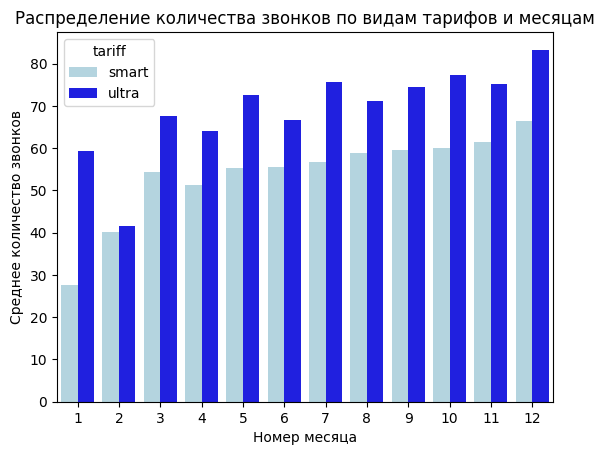

In [48]:
import seaborn as sns

ax = sns.barplot(x='month',
            y='calls_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение количества звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество звонков');

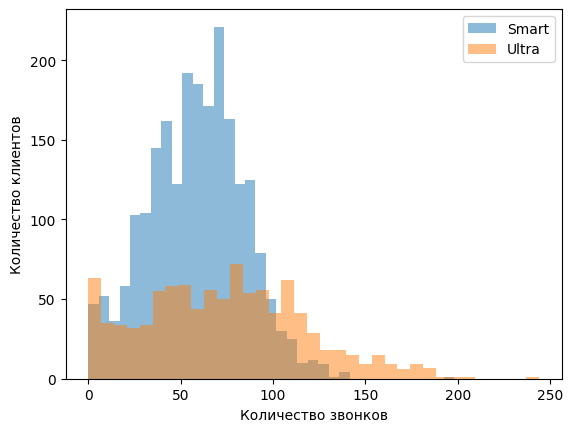

In [49]:
import matplotlib.pyplot as plt

user_behavior.groupby('tariff')['calls'].plot(kind='hist', bins=35, alpha=0.5)
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество звонков')
plt.ylabel('Количество клиентов')
plt.show()

Распределение средней продолжительности звонков по видам тарифов и месяцам

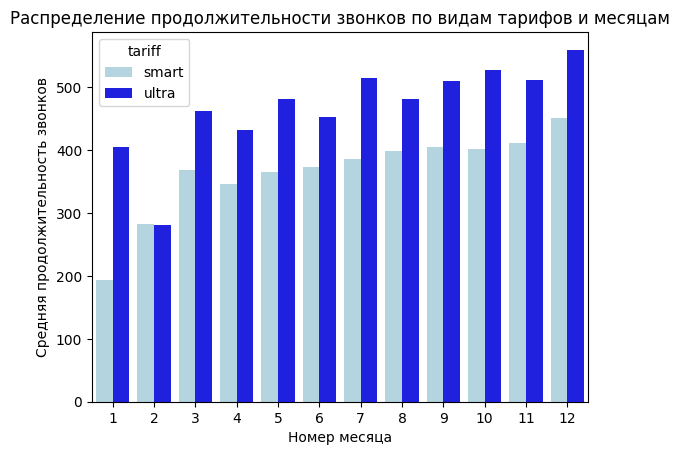

In [50]:
ax = sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue'])

ax.set_title('Распределение продолжительности звонков по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Средняя продолжительность звонков');

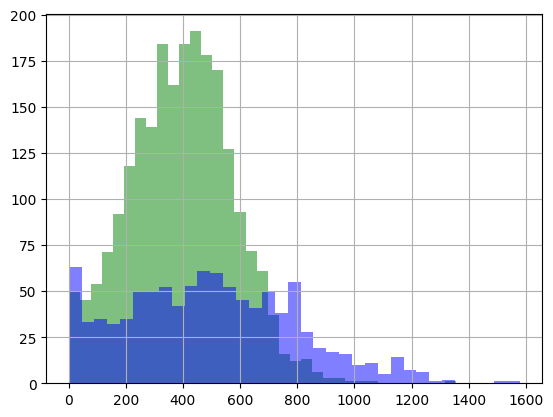

In [51]:
user_behavior[user_behavior['tariff'] =='smart']['minutes'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['minutes'].hist(bins=35, alpha=0.5, color='blue');

Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

Распределение среднего количества сообщений по видам тарифов и месяцам

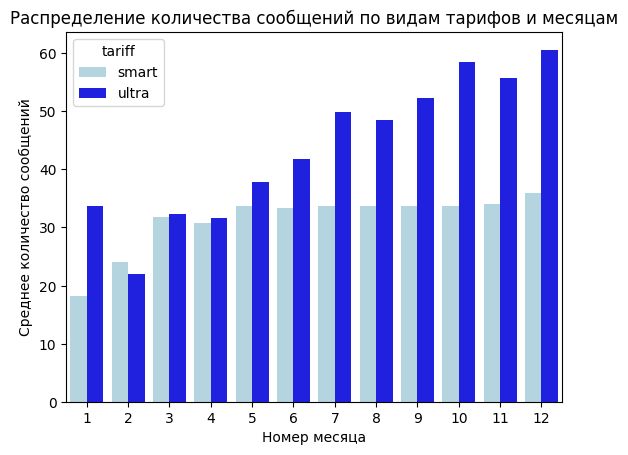

In [52]:
ax = sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества сообщений по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество сообщений');

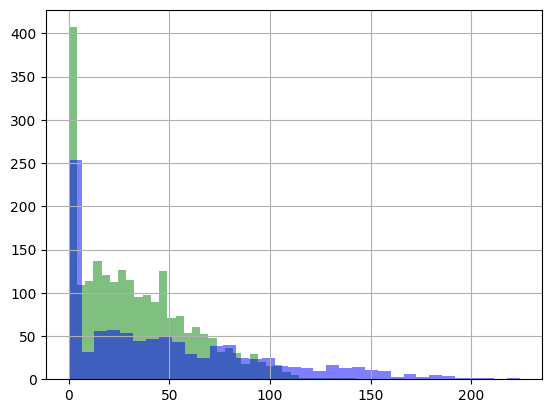

In [53]:
user_behavior[user_behavior['tariff'] =='smart']['messages'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['messages'].hist(bins=35, alpha=0.5, color='blue');

В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.

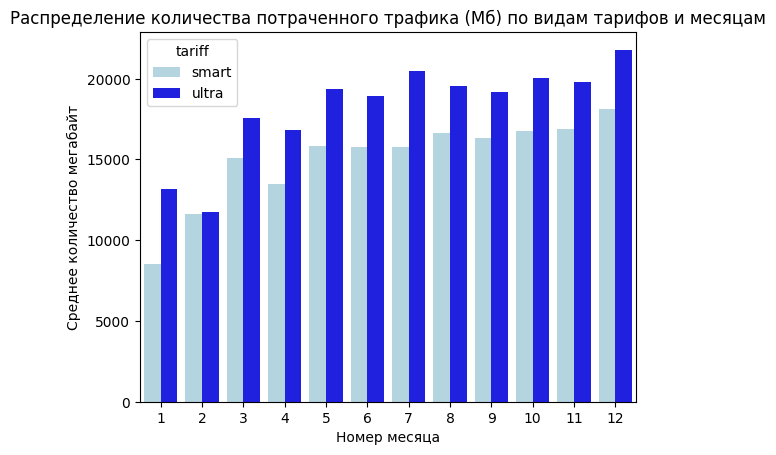

In [54]:
ax = sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['lightblue', 'blue']
)

ax.set_title('Распределение количества потраченного трафика (Мб) по видам тарифов и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Среднее количество мегабайт');

Сравнение потраченных мегабайт среди пользователей тарифов Smart и Ultra

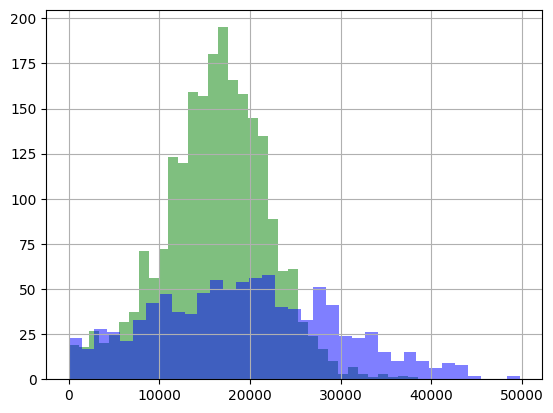

In [55]:
user_behavior[user_behavior['tariff'] =='smart']['mb_used'].hist(bins=35, alpha=0.5, color='green')
user_behavior[user_behavior['tariff'] =='ultra']['mb_used'].hist(bins=35, alpha=0.5, color='blue');

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.

### Проверка гипотез

Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

```
H_0: Выручка (total_cost) пользователей "Ультра" = выручка (total_cost) пользователей "Смарт"`
H_a: Выручка (total_cost) пользователей "Ультра" ≠ выручка (total_cost) пользователей "Смарт"`
alpha = 0.05
```

In [56]:
from scipy import stats as st

In [58]:
total_cost_smart = user_behavior[user_behavior['tariff'] =='smart']['total_cost']
total_cost_ultra = user_behavior[user_behavior['tariff'] =='ultra']['total_cost']
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(total_cost_smart, total_cost_ultra,equal_var=False)
# alpha = задайте значение уровня значимости
alpha = .05
# вывод значения p-value на экран
#print('p-значение:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print(results.pvalue)
    print("Отвергаем нулевую гипотезу")
else:
    print(results.pvalue)
    print("Не получилось отвергнуть нулевую гипотезу")

3.023984607909521e-274
Отвергаем нулевую гипотезу


Проверка гипотезы: пользователи из Москвы приносят больше выручки, чем пользователи из других городов;

```
H_0: Выручка (total_cost) пользователей из Москвы = выручка (total_cost) пользователей не из Москвы`
H_1: Выручка (total_cost) пользователей из Москвы ≠ выручка (total_cost) пользователей не из Москвы`
alpha = 0.05
```

In [59]:
total_cost_mos = user_behavior[user_behavior['city'] =='Москва']['total_cost']
total_cost_reg = user_behavior[user_behavior['city'] !='Москва']['total_cost']
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(total_cost_mos, total_cost_reg, equal_var=False)
# alpha = задайте значение уровня значимости
alpha = .05
# вывод значения p-value на экран 
print('p-значение:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print(results.pvalue)
    print("Отвергаем нулевую гипотезу")
else:
    print(results.pvalue)
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.46411900164961384
0.46411900164961384
Не получилось отвергнуть нулевую гипотезу
